<div class="alert alert-block alert-info">
    <b>Code:</b> Ivana Sánchez Olivares
</div>

# <font color='blue'>Hackathon   Baker Hughes.</font> 

## <font color='pink'>DS Hackathon 2022 - Predictive Modeling</font>

### <font color='pink'>Team: Serival Tree Team</font>

In [1]:
!pip install progressbar
!pip install torch
!pip install opendatasets --upgrade --quiet

In [2]:
import progressbar
import opendatasets as od
import plotly.express as px
import seaborn as sns
import torch
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Para los modelos
from torch import nn
from torch import optim
from progressbar import ProgressBar
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
matplotlib.style.use('ggplot')
%matplotlib inline

# Para la carga de datos
import os
import glob

In [3]:
dataset_url = 'https://www.kaggle.com/c/48fe736d-d85a-4e97-b362-5f045be3c5ec/data'

In [4]:
od.download(dataset_url) 
# Cuando les pida mi API key es {"username":"sergiomr04","key":"60c35d2b85632bec0862e8d07822807e"}

Skipping, found downloaded files in "./48fe736d-d85a-4e97-b362-5f045be3c5ec" (use force=True to force download)


In [5]:
path = r'/content/48fe736d-d85a-4e97-b362-5f045be3c5ec/train'
all_files = glob.glob(os.path.join(path, "*.csv"))

In [6]:
names = [os.path.basename(x) for x in glob.glob(path+'\*.csv')]
df = pd.DataFrame()

for file_ in all_files:
    file_df = pd.read_csv(file_)
    file_df['FILE_ID'] = file_
    df = df.append(file_df)
#print(df)

In [7]:
#Usamos el mismo código que en el data analysis para obtener y juntar correctamente las bases de datos del train
df["FILE_ID"]=df["FILE_ID"].str.extract(r'(data_[0-9]{2,3}\.csv)')
Engie=pd.read_csv("/content/48fe736d-d85a-4e97-b362-5f045be3c5ec/site_metadata.csv") 
site=pd.read_csv("/content/48fe736d-d85a-4e97-b362-5f045be3c5ec/engine_metadata.csv").drop(columns=["CUSTOMER_NAME"])
engine_customer=Engie.merge(site,how="left",on="PLANT_NAME")
df_full=df.merge(engine_customer,how="left",on="FILE_ID")
df_full.to_csv("Datos_full.csv") 

In [8]:
df_full = df_full.dropna() #No se utilizan los NaN para el entrenamiento, esto debido al análisis que hicimos previamente

In [9]:
df_full.info() #Trabajaremos con 4337 datos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4337 entries, 3 to 5489
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4337 non-null   object 
 1   T_AMB          4337 non-null   float64
 2   P_AMB          4337 non-null   float64
 3   CMP_SPEED      4337 non-null   float64
 4   CDP            4337 non-null   float64
 5   GGDP           4337 non-null   float64
 6   HPT_IT         4337 non-null   float64
 7   CDT            4337 non-null   float64
 8   LPT_IT         4337 non-null   float64
 9   EXH_T          4337 non-null   float64
 10  RH             4337 non-null   float64
 11  WAR            4337 non-null   float64
 12  POWER          4337 non-null   float64
 13  FILE_ID        4337 non-null   object 
 14  CUSTOMER_NAME  4337 non-null   object 
 15  PLANT_NAME     4337 non-null   object 
 16  LATITUDE       4337 non-null   float64
 17  LONGITUDE      4337 non-null   float64
 18  ELEVATIO

In [10]:
df_full.columns #El nombre de las columnas de nuestra base de datos

Index(['date', 'T_AMB', 'P_AMB', 'CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT',
       'LPT_IT', 'EXH_T', 'RH', 'WAR', 'POWER', 'FILE_ID', 'CUSTOMER_NAME',
       'PLANT_NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'ENGINE_ID'],
      dtype='object')

In [11]:
#Debido al análisis final de correlación de variables, se decide unicamente utilizar quellas que tengan una correlación
#con valor absoluto mayor a 0.5, entonces quitamos todas aquellas que no lo cumplen
df_full.drop(['date', 'T_AMB','P_AMB','RH','WAR','LATITUDE','LONGITUDE','ELEVATION','FILE_ID','CUSTOMER_NAME','PLANT_NAME','ENGINE_ID'], axis=1, inplace=True)

In [12]:
#La funicón normalización estandariza los valores para que se manejen de mejor manera
#en la red neuronal.
def Normalizacion(categoria,data):
  mean_categoria=data[categoria].mean() #media de la columna
  std_categoria=data[categoria].std() # desviación de la columna
  data[categoria]=data[categoria].apply(lambda x: (x - mean_categoria)/std_categoria) #(x-media) / desviación

In [13]:
df_full.columns #Observamos las columnas que si usaremos

Index(['CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT', 'LPT_IT', 'EXH_T',
       'POWER'],
      dtype='object')

In [14]:
#Guardamos los valores de media y desviación que después serán útilies
media_POWER=df_full['POWER'].mean() 
desviacion_POWER=df_full['POWER'].std()

In [15]:
cat=['CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT', 'LPT_IT', 'EXH_T','POWER']

for i in cat:
  Normalizacion(i,df_full)
  #Normalizamos el data fram

df_full.head() #DataFrame con las vairables normalizadas

,CMP_SPEED,CDP,GGDP,HPT_IT,CDT,LPT_IT,EXH_T,POWER
3,-2.880761,-1.937346,-2.405356,0.064161,-3.298847,-0.013167,-0.061635,-0.252301
7,-3.426539,-2.329655,-2.855739,0.948023,-4.084627,1.172935,1.255800,-1.583131
8,-1.075770,-1.367737,-1.330694,1.188289,-0.560103,1.355491,1.408506,-1.600704
9,-1.076521,-1.402233,-1.370998,1.521981,-0.424687,1.613020,1.626775,-1.628665
10,-1.116292,-1.429640,-1.403121,1.529042,-0.485593,1.640889,1.665904,-1.663374


In [16]:
data=df_full #Renombro data como df_full

In [17]:
msk = np.random.rand(len(data)) < 0.80
training_data = data[msk] #el 80 % son para entrenamiento 
test_data = data[~msk] #el 20% para prueba 


In [18]:
class DataFrameDataset(Dataset):
  def __init__(self, data, x_names:list, y_name):
    X = data[x_names] #variables explicativas
    Y = data[y_name] # -> una columna del dataframe, variable a predecir
    self.X = torch.from_numpy(X.to_numpy()).to(dtype=torch.float32)
    self.Y = torch.from_numpy(Y.to_numpy()).to(dtype=torch.float32)

  def __len__(self):
    return self.Y.size()[0]

  def __getitem__(self, idx):
    x = self.X[idx, :]
    y = self.Y[idx]
    return x, y

In [19]:
class LinearNet(nn.Module):
  #Modelo 
  def __init__(self,n_in, n_out):
    super(LinearNet, self).__init__()

    ## transformaciones afines: z = Wx + b para las tres capas
    self.layer1 = nn.Linear(in_features=n_in, out_features=7, bias=True)
    self.layer2 = nn.Linear(in_features=7, out_features=7, bias=True)
    self.layer3 = nn.Linear(in_features=7, out_features=n_out, bias=True)

    #Funciones de activación
    self.fc1 = nn.ELU()
    self.fc2 = nn.Sigmoid()

    self.in_features = n_in

  def forward(self, x):
    x = self.layer1(x)
    x = self.fc1(x)
    x = self.layer2(x)
    x = self.fc2(x)
    x = self.layer3(x)
    return x

In [20]:
#Usamos la clase DataFrameDataset para utilizar correctamente los datos de entrenamiento y prueba
x_names = ['CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT', 'LPT_IT', 'EXH_T'] #variables explicativas
train_set = DataFrameDataset(training_data, x_names, 'POWER') #entrenamiento
test_dataset = DataFrameDataset(test_data, x_names, 'POWER') #test

In [21]:
#Ahora de los datos de prueba, vamos a obtener los datos de validación, los cuales eran el 75% de los de prueba.
msk = np.random.rand(len(test_dataset)) < 0.75
val_set = torch.utils.data.Subset(test_dataset, np.where(msk)[0]) #validación
test_set = torch.utils.data.Subset(test_dataset, np.where(~msk)[0]) #test
n_test = len(test_set)

In [22]:
#Definimos el bach size pues son pocos datos 
batch_size = 1

#Definimos el train, val y test a usar de los previos
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=n_test)

In [23]:
#Definimos el modelo
model = LinearNet(7,1)
model

LinearNet(
  (layer1): Linear(in_features=7, out_features=7, bias=True)
  (layer2): Linear(in_features=7, out_features=7, bias=True)
  (layer3): Linear(in_features=7, out_features=1, bias=True)
  (fc1): ELU(alpha=1.0)
  (fc2): Sigmoid()
)

In [25]:
#Funcion de costos
cost = nn.MSELoss()
#Optimizador que utiliza el método del gradiente 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.05, nesterov=False)
#Oprimizador que utiliza Adadelta
#optimizer = optim.Adadelta(model.parameters(), lr=0.01, rho=0.05, eps=1e-09, weight_decay=0.0)

In [26]:
def update_parameters(model, dataloader, optimizer, criterion, train=True):
  #Para entrenamiento
  running_loss = 0.0
  for i, data in enumerate(dataloader, 0):
    X, Y = data
    n = len(X) #numero de parametros que van a estimar a Y
    X = X.reshape((n, model.in_features)) # Corrección de tamaño, sólo es necesario en dim=1
    m = len(Y)
    Y = Y.reshape((m, 1)) # -> Corrección de tamaño
    if train: 
      optimizer.zero_grad() # reinicia el gradiente
    pred = model(X) # forward pass 
    loss = criterion(pred, Y) # evaluación de predicción
    if train:
      loss.backward() # cálcula las derivadas 
      optimizer.step() # paso de optimización 

    running_loss += loss.item()
    avg_loss = running_loss/(i + 1)
  return avg_loss

In [27]:
epoch_loss = list()
val_loss = list()
epochs = 150

for epoch in range(epochs):
  #Para cada epcoh se obteiene el loss_train y loss_val
  #nos interesa un loss_val pequeño 
  loss_train = update_parameters(model, train_dataloader, optimizer, cost)
  loss_val = update_parameters(model, val_dataloader, None, cost, train=False)
  epoch_loss.append(loss_train)
  val_loss.append(loss_val)
  if epoch % 5 == 0:  
    print('epoch {}, train loss {}, val loss {}'.format(epoch, loss_train, loss_val))

epoch 0, train loss 0.15144057269827257, val loss 0.03578846060249575
epoch 5, train loss 0.006089794516165593, val loss 0.006224005249147065
epoch 10, train loss 0.0045002651320684125, val loss 0.006039915965659096
epoch 15, train loss 0.0035100530307256355, val loss 0.0038747165300448295
epoch 20, train loss 0.0028053394955942198, val loss 0.002742739915251753
epoch 25, train loss 0.0022361160139940128, val loss 0.0016480571458865583
epoch 30, train loss 0.0021680636898113114, val loss 0.0013318571452111052
epoch 35, train loss 0.0018544926480279025, val loss 0.001172962335447107
epoch 40, train loss 0.001558451148036022, val loss 0.0012866638155258638
epoch 45, train loss 0.0014255308485312042, val loss 0.0012968214728896117
epoch 50, train loss 0.0014930439924749658, val loss 0.00119169966249744
epoch 55, train loss 0.0015282960183997352, val loss 0.0009035335659229318
epoch 60, train loss 0.001302049124312803, val loss 0.0008992385635738226
epoch 65, train loss 0.00111256455256128

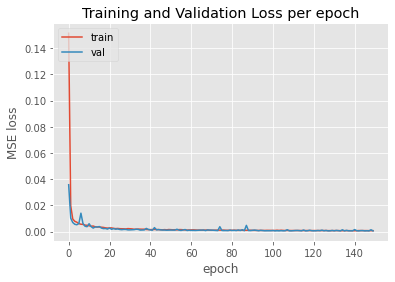

In [28]:
#Para graficar los epoch y los val_loss que se han obtenido
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss per epoch')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
data = next(iter(test_dataloader))
X, Y = data
n = len(Y)
Y = Y.reshape((n, 1)) # -> Corrección de tamaño
pred = model(X)
error = cost(Y, pred) #comparamos los valores reales con el modelo 
print('error de prueba :{}'.format(error.item())) #error de prueba medido con la función cost

error de prueba :0.0004707508778665215


In [30]:
from google.colab import drive 
drive.mount('/content/gdrive') #Cargamos el drive donde está la base del test_data

Mounted at /content/gdrive


In [31]:
#Cargamos nuestra base de datos
datanueva=pd.read_csv('gdrive/My Drive/Hackathon/test_data_123.csv')

In [32]:
BaseFechas=datanueva['date'] #Obtenemos la columna correpsondientea las fechas

In [33]:
datanueva.columns #nombre de las columnas

Index(['date', 'T_AMB', 'P_AMB', 'CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT',
       'LPT_IT', 'EXH_T', 'RH', 'WAR'],
      dtype='object')

In [34]:
datanueva.drop(['date', 'T_AMB','P_AMB','RH','WAR'], axis=1, inplace=True) #Quitamos las variables que nos e usan en nuestor modelo 

In [35]:
cat=['CMP_SPEED', 'CDP', 'GGDP', 'HPT_IT', 'CDT', 'LPT_IT', 'EXH_T']  

for i in cat:
  Normalizacion(i,datanueva)
  #SAe normalizan las variables a usar

datanueva.head() #Vemos la base de datos normalizada

,CMP_SPEED,CDP,GGDP,HPT_IT,CDT,LPT_IT,EXH_T
0,0.066152,-0.306081,-0.076303,0.525491,0.324186,0.644592,0.677870
1,0.070929,-0.304943,-0.075243,0.572999,0.339084,0.672685,0.697691
2,0.040968,-0.356976,-0.123870,0.777438,0.346818,0.836319,0.844867
3,0.059681,-0.341183,-0.108971,0.825019,0.377893,0.852547,0.847437
4,-0.234088,-0.527149,-0.356194,0.781818,0.008779,0.821877,0.821988


In [36]:
datanueva.info()#Vemos su info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CMP_SPEED  366 non-null    float64
 1   CDP        366 non-null    float64
 2   GGDP       366 non-null    float64
 3   HPT_IT     293 non-null    float64
 4   CDT        366 non-null    float64
 5   LPT_IT     293 non-null    float64
 6   EXH_T      293 non-null    float64
dtypes: float64(7)
memory usage: 20.1 KB


In [37]:
#Convertimos la base a un tensor de torch 
nuevita = np.array(datanueva) #se obtiene un array del dataframe
final = torch.tensor(nuevita) #convertimos a torch
final=final.type(torch.FloatTensor) #tensor tipo float

In [39]:
Prueba= model(final) #Obtenemos la predicción
Aver=Prueba.detach().numpy() #lo pasamos a numpy array
Aver

array([[-0.75155175],
       [-0.7311852 ],
       [-0.7467699 ],
       [-0.6987463 ],
       [-0.7622316 ],
       [        nan],
       [ 0.0847463 ],
       [ 0.46855462],
       [ 0.51783633],
       [ 0.5290891 ],
       [ 0.51425296],
       [ 0.48681098],
       [ 0.45790315],
       [ 0.4686947 ],
       [ 0.53009623],
       [ 0.55222076],
       [ 0.49755388],
       [ 0.4299798 ],
       [ 0.35240525],
       [ 0.33632284],
       [ 0.3670126 ],
       [ 0.40574175],
       [ 0.38009843],
       [ 0.28248417],
       [ 0.2453998 ],
       [ 0.294173  ],
       [ 0.36630267],
       [ 0.40861517],
       [ 0.3718087 ],
       [ 0.29804543],
       [ 0.24817413],
       [ 0.2231188 ],
       [ 0.28500855],
       [ 0.33800793],
       [ 0.29415518],
       [ 0.26290601],
       [ 0.19106771],
       [        nan],
       [-0.8196639 ],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [  

In [40]:
Base=pd.DataFrame(Aver, columns =['POWER']) #HAcemos el data Frame con el modelo
BaseFinal = [BaseFechas, Base['POWER']]
headers = ["date", "POWER"]

#unimos el POWER que se predice con las fechas correspondientes
df3 = pd.concat(BaseFinal, axis=1, keys=headers)
df3

,date,POWER
0,2021-01-01,-0.751552
1,2021-01-02,-0.731185
2,2021-01-03,-0.746770
3,2021-01-04,-0.698746
4,2021-01-05,-0.762232
...,...,...
361,2021-12-28,0.608375
362,2021-12-29,0.682873
363,2021-12-30,0.691250
364,2021-12-31,0.710952


In [41]:
df3.info() #Vemos la información. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   POWER   293 non-null    float32
dtypes: float32(1), object(1)
memory usage: 4.4+ KB


In [42]:
#Se quita la normalización de power utilizando la funicón inversa de (x-media)/desviación
df3['POWER']=df3['POWER'].apply(lambda x: desviacion_POWER * x + media_POWER)


In [43]:
df3['POWER'] = df3['POWER'].fillna(0) #Lenamos los na con 0

In [44]:
df3.info() #Vemos que no haya nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   POWER   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [45]:
Array = df3[['date']].to_numpy() #Obtenemos un array de las fechas, vamos a cmabiar su formato.

In [46]:
def formatito (jj):
  #jj es una fecha, que se encuentra en formado array eg.['2021-01-01']

  ll=jj.split('-')#Separa los string de fecha cada vez que ve '-'
  p=len(ll)#longitud de la separación, siempre será 3, pues queda en año, mes, día

  for i in range(0,p):
    temp=int(ll[i]) #El str lo vonertimos a int
    ll[i]=str(temp) #y ahora d eint a str 
    #Esto causa que los str '01' mediante esta funicón terminen siendo el string '1'
  for i in range(0,p):
    #Ahora intertimos el orden, intercambiamos el mes por día y el día por mes
    if i==1:
      tempo=ll[i]
      tempa=ll[i+1]
      ll[i+1]=tempo
      ll[i]=tempa
    
  ll.reverse() #Ponemos la fecha al revés, es decir, en el formato mes/día/año 
  nuevall=['/'.join(ll)]#Unimos los str por '/'
  return(nuevall) #Regresamos el formato correcto de fecha

In [47]:
def formatos (Array):
  #Array es el Array de fechas
  NuevoArray=[] #Sera el array donde estarán las fechas con formato correcto
  renglones,columnas=Array.shape 
  for i in range(0,renglones):
    for j in range(0,columnas):
      #Para cada fecha
      jj=Array[i,j] #aplicamos el formato correcto
      NuevoArray.append(formatito(jj)) #lo agregamos al array
  NuevoArray=np.array(NuevoArray)
  return(NuevoArray) 



In [48]:
Konda= formatos(Array)
Konda #Array correcto de fechas

array([['1/1/2021'],
       ['1/2/2021'],
       ['1/3/2021'],
       ['1/4/2021'],
       ['1/5/2021'],
       ['1/6/2021'],
       ['1/7/2021'],
       ['1/8/2021'],
       ['1/9/2021'],
       ['1/10/2021'],
       ['1/11/2021'],
       ['1/12/2021'],
       ['1/13/2021'],
       ['1/14/2021'],
       ['1/15/2021'],
       ['1/16/2021'],
       ['1/17/2021'],
       ['1/18/2021'],
       ['1/19/2021'],
       ['1/20/2021'],
       ['1/21/2021'],
       ['1/22/2021'],
       ['1/23/2021'],
       ['1/24/2021'],
       ['1/25/2021'],
       ['1/26/2021'],
       ['1/27/2021'],
       ['1/28/2021'],
       ['1/29/2021'],
       ['1/30/2021'],
       ['1/31/2021'],
       ['2/1/2021'],
       ['2/2/2021'],
       ['2/3/2021'],
       ['2/4/2021'],
       ['2/5/2021'],
       ['2/6/2021'],
       ['2/7/2021'],
       ['2/8/2021'],
       ['2/9/2021'],
       ['2/10/2021'],
       ['2/11/2021'],
       ['2/12/2021'],
       ['2/13/2021'],
       ['2/14/2021'],
       ['2/15/2021'],
      

In [49]:
Fechisimas = pd.DataFrame(Konda)
Fechisimas #Data frame de fechas correcto

,0
0,1/1/2021
1,1/2/2021
2,1/3/2021
3,1/4/2021
4,1/5/2021
...,...
361,12/28/2021
362,12/29/2021
363,12/30/2021
364,12/31/2021


In [50]:
df3['date']=Fechisimas.values 
df3 #concatemamos power con las fechas. 

,date,POWER
0,1/1/2021,8730.297651
1,1/2/2021,8811.593397
2,1/3/2021,8749.384999
3,1/4/2021,8941.077407
4,1/5/2021,8687.667668
...,...,...
361,12/28/2021,14158.623919
362,12/29/2021,14455.991233
363,12/30/2021,14489.428235
364,12/31/2021,14568.072841


In [51]:
df3.to_csv('PruebaMMM.csv',index=False) #Guardamos el csv del data framen sin índices